In [1]:
from  recognition.chronicle_recognition import Chronicle
from seq_generation.chronicle_generator import *
from monitoring2 import *
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from LSTM.LSTMtrainBin  import *
from LSTM.LSTMmonotoring import *
from memory_profiler import memory_usage

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
GPU found


In [2]:

ofile='./LSTM/output_files/data/%s'
ifile='./LSTM/input_data/%s'

def filterseq(DBseq):
    seqs=[]
    for seq in DBseq:
        #seqs.append([(t,e) for (t,e) in seq if e in c.sequence])
        seqs.append([(t,e) for (t,e) in seq if e != -1])
    return [s for s in seqs if len(s)>1]

"UCAD.csv , LSTM.csv"
def savescore(filename,p,r,f,e,mu):
    with open(ofile % filename, 'a+') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        #spamwriter.writerow(["CaseID", "nb ch","nbseq","per", "accuracy", "recall", "f1 score", "execution time","memory usage"])
        spamwriter.writerow(['*',nbc,nbseq,pert,p,r,f,e,mu,nbitems,seqlen])
        
import re 
def deserialization(input):  
     # \d+ is a regular expression which means 
     # one or more digit 
     # output will be like ['100','564','365'] 
    numbers = re.findall('\d+',input) 

     # now we need to convert each number into integer 
     # int(string) converts string into integer 
    numbers = list(map(int,numbers))
    l=[]
    for i in range(0,len(numbers)-1,2):
        l.append((numbers[i],numbers[i+1]))
    return l

def read_text_file(filename):
    print('Reading file ' + filename + "...")
    with open(filename, "r", encoding='utf8') as textfile:
        L = []
        for line in textfile:
            L.append(line.strip())
        print('File contains ', len(L), "lines.\n")
        return L

def serialization(seqs,filename):
     with open(ifile%filename, "w+") as fichier:
        for seq in seqs:
            fichier.write(str(seq).strip('[]')+'\n')
            
def serialization2(seqs,filename):
     with open(ifile%filename, "w+") as fichier:
        for seq in seqs:
            s=[i[1] for i in seq ]
            fichier.write(str(s).strip('[]')+'\n')
import pickle          
def saveobj(filename,obj):
    with open(ofile% filename, 'wb') as config_file:
        pickle.dump(obj, config_file)
        
def loadobj(filename):
    with open(ofile% filename, 'rb') as config_file:
        return pickle.load(config_file)

def makelabel(seqs):
    seqs_label=[]
    for seq in seqs :
        if len(seq)==0:
            #DB_seq_label.append(0)
            seqs.remove(seq)
        if len(seq)==1:
            seqs.remove(seq)
        else:
            seqs_label.append(1)
    return seqs_label

def learn_threshold(predict,label):
    ss=[i for i in np.arange(1, .025, -0.025)]
    #ss=[1,0.95,.9,.85,.8,.75,.7,.65,.6,.55,.5,.45,.4,.35,.3,.25,.2]
    fl=[]
    f=0
    seuil=0
    for s in ss:
        y_pred=decision(predict,s)
        f1=metrics.f1_score(label, y_pred, average='macro')
        fl.append(f1)
        if(f<f1):
            f=f1
            seuil=s
    return ss,fl,f,seuil

import numpy as np
import matplotlib.pyplot as plt
def plot_threshold(ss,fl,f,seuil):
    plt.plot(ss, fl, label='seuil') #blue
    plt.plot([seuil], [f],'rx',markersize=6) #red
    plt.xlabel("seuil")
    plt.ylabel("F1-score")
    plt.gca().invert_xaxis()
    plt.legend()
    plt.show() # affiche la figure a l'ecran

def plot_ROC(test_labels, test_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(
        test_labels, test_predictions, pos_label=1)
    auc = "%.2f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "#000099", label='ROC curve')
        ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.title(title)
    return fig

############ Generate Data #####################
################################################

In [3]:
print("====================\nChronicle DB generation\n====================\n")
generator=chrodb_generator(nbitems=50,l=8, lp=8)
sequences = generator.generate(nb=100, l=25, npat=30, th=0.5)
pp=generator.patterns
print(len(pp))
print("======== PATTERNS =======")
DB_c=[ch for ch in generator.all_patterns()]
#saveobj("DB_c.dictionary",DB_c)
nbc=len(DB_c)
DB_ch=[affectation(ch) for ch in generator.all_patterns()]
DB_seq=[s.seq for s in sequences]
#for i in DB_ch:
#    print(i)
    
print(len(DB_seq))
DB_seq=filterseq(DB_seq)
print(len(DB_seq))
DB_seq_label=makelabel(DB_seq)
print(len(DB_seq))
assert (len(DB_seq)==len(DB_seq_label))

#DB_ch=sort_db_ch(DB_ch)    
print("======== make_noise in CH DB =======")
#p,c=make_noise(DB_c,0.3,200)
pert=.3
c,p =split_db_ch(DB_c,per=pert)
print(len(p))

print("======== p sequence generation =======")
ch=p
p_se=generator.generate(nb=300, l=15, npat=len(ch), th=.5,patterns=ch,pert=0)
p_seq0=[s.seq for s in p_se]

p_seq1=[s.seq  for s in generator.generate(nb=200, l=25, npat=len(ch), th=.5,patterns=ch,pert=1)]
p_seq0=filterseq(p_seq0)
p_seq1=filterseq(p_seq1)
print(len(p_seq0))
print(len(p_seq1))
print(len(DB_seq))


Chronicle DB generation

30
======== PATTERNS =======
100
100
100
======== make_noise in CH DB =======
9
======== p sequence generation =======
300
199
100


C:\Users\SDC\Documents\nasreddine\anomalie-detection-v3\Anomaly_Prediction\seq_generation\chronicle_generator.py:133: UserWarning: *** Minimisation: Inconsistent chronicle ***
  warnings.warn("*** Minimisation: Inconsistent chronicle ***")


In [12]:

i=0
saveobj("ch{0}/DB_c{0}.dictionary".format(i),DB_c)
saveobj("ch{0}/DB_seq{0}.dictionary".format(i),DB_seq)
saveobj("ch{0}/DB_lseq{0}.dictionary".format(i),DB_seq_label)
saveobj("ch{0}/p_seq0{0}.dictionary".format(i),p_seq0)
saveobj("ch{0}/p_seq1{0}.dictionary".format(i),p_seq1)


############ Load Data ##############
######################################

In [3]:
print("############ Load Data ##############")
i=15
data=[15]
DB_c ,DB_seq,DB_seq_label,p_seq0,p_seq1,DB_ch=[],[],[],[],[],[]
for i in data:
    DB_c=DB_c+loadobj("ch{0}/DB_c{0}.dictionary".format(i))
    DB_ch=DB_ch +[affectation(ch) for ch in DB_c]
    DB_seq=DB_seq+loadobj("ch{0}/DB_seq{0}.dictionary".format(i))
    DB_seq_label=DB_seq_label+loadobj("ch{0}/DB_lseq{0}.dictionary".format(i))
    p_seq0=p_seq0+loadobj("ch{0}/p_seq0{0}.dictionary".format(i))
    p_seq1=p_seq1+loadobj("ch{0}/p_seq1{0}.dictionary".format(i))
print(len(p_seq0))
print(len(p_seq1))
print(len(DB_seq))
print(len(DB_c))
assert (len(DB_seq)==len(DB_seq_label))
nbseq=len(DB_seq)
nbc=len(DB_c)
pert=.3
trainseq=loadobj("ch{0}/trainseq.dictionary".format(i))
BCL=loadobj("ch{0}/BCL.dictionary".format(i))
len(trainseq)

############ Load Data ##############
91
181
970
30


29

In [6]:
print(DB_c[2])

C62: {[108, 109, 103, 104, 108, 109, 103, 104, 108, 109]}
0,1: (0, 0)
0,2: (-inf, inf)
0,3: (-inf, inf)
0,4: (-inf, inf)
0,5: (-inf, inf)
0,6: (-inf, inf)
0,7: (-inf, inf)
0,8: (-inf, inf)
0,9: (-inf, inf)
1,2: (0, 762060)
1,3: (-inf, inf)
1,4: (-inf, inf)
1,5: (-inf, inf)
1,6: (0, 765300)
1,7: (-inf, inf)
1,8: (-inf, inf)
1,9: (-inf, inf)
2,3: (0, 0)
2,4: (0, 0)
2,5: (0, 0)
2,6: (-inf, inf)
2,7: (-inf, inf)
2,8: (-inf, inf)
2,9: (-inf, inf)
3,4: (0, 0)
3,5: (0, 0)
3,6: (-inf, inf)
3,7: (-inf, inf)
3,8: (-inf, inf)
3,9: (-inf, inf)
4,5: (0, 0)
4,6: (-inf, inf)
4,7: (-inf, inf)
4,8: (-inf, inf)
4,9: (-inf, inf)
5,6: (0, 765300)
5,7: (-inf, inf)
5,8: (-inf, inf)
5,9: (-inf, inf)
6,7: (0, 0)
6,8: (0, 0)
6,9: (0, 0)
7,8: (0, 0)
7,9: (0, 0)
8,9: (0, 0)
tid:[]



In [21]:
DBt=loadobj("reel/seqs.data")
p_seq1=loadobj("reel/seqAN.data")
DB_seq=loadobj("reel/seqN.data")
DB_c=loadobj("reel/ch.data")
DB_ch=[affectation(c) for c in DB_c  ]
p_seq0=[]

In [5]:
############### generate train seq for LSTM ######################
#ch=DB_c
trainseq=[]
nbitems=20 #nb vocab
seqlen=10 #len ch
#generator=chrodb_generator(nbitems=10,l=25, lp=15)
#dd=[DB_c[16],DB_c[1]]
data=[]
#m=[15,35,50,70,90,120,170,230,300,350]
m=[50]
for i,ch in enumerate(DB_c[:]):
    for k in m:
        ps=generator.generate(nb=5, l=k, npat=len([ch]), th=.5,patterns=[ch],pert=-2)
        pseq=filterseq([s.seq for s in ps])
        print(len(ps))
        if len(pseq)!=0:
    #    print(i,len(pseq))
            trainseq.extend([s.seq for s in ps])
trainseq
print(len(trainseq))
#print([ print(i.sequence) for i in DB_c])
print(len(DB_c))
#print(trainseq[20:])
trainseq

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
150
30


[[(12, -1),
  (16, -1),
  (23, -1),
  (24, -1),
  (52, -1),
  (92, -1),
  (102, -1),
  (106, -1),
  (117, -1),
  (168, -1),
  (180, -1),
  (197, -1),
  (200, -1),
  (213, -1),
  (220, -1),
  (234, -1),
  (248, -1),
  (275, -1),
  (288, -1),
  (298, -1),
  (317, -1),
  (321, -1),
  (332, -1),
  (373, -1),
  (375, -1),
  (388, -1),
  (401, -1),
  (403, 18),
  (406, -1),
  (411, -1),
  (412, -1),
  (417, -1),
  (451, -1),
  (469, 33),
  (497, -1),
  (515, 42),
  (641, 8),
  (645, -1),
  (653, -1),
  (703, -1),
  (727, -1),
  (735, -1),
  (768, -1),
  (768, -1),
  (776, -1),
  (787, -1),
  (797, -1),
  (820, 30),
  (892, 34),
  (926, -1),
  (930, -1),
  (937, 44),
  (957, -1),
  (997, -1),
  (998, -1),
  (998, -1)],
 [(25, -1),
  (57, -1),
  (62, -1),
  (62, -1),
  (72, -1),
  (109, -1),
  (113, -1),
  (117, -1),
  (136, -1),
  (156, -1),
  (166, -1),
  (173, -1),
  (178, -1),
  (194, -1),
  (226, -1),
  (237, -1),
  (324, -1),
  (372, -1),
  (386, -1),
  (396, -1),
  (413, -1),
  (428, -1

In [9]:
serialization2(trainseq,"test.txt")

In [22]:
for i in DB_c[:7]:
    print(i)

C1: {[38, 6, 27, 23, 33, 6, 12, 41, 42, 20, 49, 28, 19, 28]}
0,1: (75, 127)
0,2: (113, 266)
0,3: (183, 428)
0,4: (212, 513)
0,5: (282, 695)
0,6: (348, 807)
0,7: (445, 1004)
0,8: (544, 1170)
0,9: (625, 1337)
0,10: (713, 1454)
0,11: (771, 1553)
0,12: (826, 1710)
0,13: (872, 1938)
1,2: (38, 139)
1,3: (108, 301)
1,4: (137, 386)
1,5: (207, 568)
1,6: (273, 680)
1,7: (370, 877)
1,8: (469, 1043)
1,9: (550, 1210)
1,10: (638, 1327)
1,11: (696, 1426)
1,12: (751, 1583)
1,13: (797, 1811)
2,3: (70, 162)
2,4: (99, 247)
2,5: (169, 429)
2,6: (235, 541)
2,7: (332, 738)
2,8: (431, 904)
2,9: (512, 1071)
2,10: (600, 1188)
2,11: (658, 1287)
2,12: (713, 1444)
2,13: (759, 1672)
3,4: (29, 85)
3,5: (99, 267)
3,6: (165, 379)
3,7: (262, 576)
3,8: (361, 742)
3,9: (442, 909)
3,10: (530, 1026)
3,11: (588, 1125)
3,12: (643, 1282)
3,13: (689, 1510)
4,5: (70, 182)
4,6: (136, 294)
4,7: (233, 491)
4,8: (332, 657)
4,9: (413, 824)
4,10: (501, 941)
4,11: (559, 1040)
4,12: (614, 1197)
4,13: (660, 1425)
5,6: (66, 112)
5,7: (1

In [8]:
############### generate test data ######################
nbitems=50 #nb vocab
seqlen=15 #len ch
ch=DB_c[:]
nbc=len(ch)
generator=chrodb_generator(nbitems=50,l=25, lp=15)
DB_seq=generator.generate(nb=50, l=25, npat=len(ch), th=.5,patterns=ch,pert=-1)
p_seq0=generator.generate(nb=20, l=25, npat=len(ch), th=.5,patterns=ch,pert=0)
p_seq1=generator.generate(nb=20, l=25, npat=len(ch), th=.5,patterns=ch,pert=1)

#p_seq0=filterseq([s.seq for s in p_seq0])
#p_seq1=filterseq([s.seq for s in p_seq1])
#DB_seq=filterseq([s.seq for s in DB_seq])
DB_seq_label=len(DB_seq)*[1]
#trainseq.extend(pseq)
print(len(DB_seq))
print(len(p_seq0))
print(len(p_seq1))

20
20
20


############### Data Frame #################
###########################################

In [36]:
nbitems=50 #nb vocab
seqlen=10 #len ch
p_seq0=[]
p_seq1=[]
DB_seq=trainseq

print("======== SEQUENCES =======")
seq_df=pd.DataFrame({'sequence':[], 'label':[]})
#DB_seq=[]
#DB_seq_label=[]
seq_df.sequence=pd.Series(DB_seq[:]+p_seq0[:]+p_seq1[:])
nbseq=len(seq_df.sequence)

seq_df.label=pd.Series(len(DB_seq[:])*[1]+len(p_seq0[:])*[1]+len(p_seq1[:])*[0])
print(seq_df.shape)
print(seq_df.head(10))

#for e in seq_df.sequence:
#    print(e)


======== SEQUENCES =======
(150, 2)
                                            sequence  label
0  [(35, -1), (51, -1), (98, -1), (260, -1), (440...      1
1  [(12, -1), (48, -1), (157, -1), (247, -1), (25...      1
2  [(1, -1), (86, 0), (117, -1), (120, -1), (210,...      1
3  [(26, -1), (271, -1), (376, -1), (411, -1), (5...      1
4  [(143, -1), (202, -1), (213, 0), (216, -1), (4...      1
5  [(70, -1), (230, -1), (238, -1), (459, -1), (4...      1
6  [(43, -1), (57, 0), (170, -1), (248, 43), (273...      1
7  [(31, -1), (144, -1), (197, -1), (219, -1), (2...      1
8  [(21, -1), (32, -1), (162, 0), (319, -1), (353...      1
9  [(12, -1), (101, -1), (126, -1), (165, -1), (2...      1


############## UCAD #######################

In [20]:
print("======== Searching for a sequence in the chronicle database I =======")
#predict=predict(DB_ch,seq_df.sequence.tolist())
#y_pred=decision(predict,1)
#predict
def UCADpred(seqs):
    start_time = time.perf_counter()
    predict=[KNN(DB_ch,seq)[0] for seq in seqs]
    end_time=time.perf_counter()
    e=end_time-start_time
    return predict,e

predict,e=UCADpred(list(seq_df.sequence))
mu=np.mean(memory_usage((UCADpred,(seq_df.sequence.tolist(),))))
print(predict)
[i for i in list(seq_df.label)]

======== Searching for a sequence in the chronicle database I =======


TypeError: 'chro_sequence' object is not iterable

In [37]:
j=0
nbc=1
pert=.3
for i in range(15,150,15):
    nbitems=np.mean([len(s) for s in list(seq_df.sequence)[j:i]])
    predict,e=UCADpred(list(seq_df.sequence)[j:i])
    mu=np.mean(memory_usage((UCADpred,(seq_df.sequence.tolist()[j:i],))))
    print(predict)

    y_pred=decision(predict,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    print(metrics.confusion_matrix(seq_df.label[j:i], y_pred))
    # Calculate the classification rate of this classifier
    p=metrics.accuracy_score(seq_df.label[j:i], y_pred)
    r=metrics.recall_score(seq_df.label[j:i], y_pred, average='macro')
    f1=metrics.f1_score(seq_df.label[j:i], y_pred, average='macro')
    p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label[j:i], y_pred, average='micro')
    print(f1,r,p)
    savescore("UCAD3.csv",p,r,f1,e,mu)
    j=i

[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[[0 0]
 [8 7]]
0.3181818181818182 0.23333333333333334 0.4666666666666667


C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
[[0 0]
 [6 9]]
0.37499999999999994 0.3 0.6
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[15]]
1.0 1.0 1.0
[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[[ 0  0]
 [ 3 12]]
0.4444444444444445 0.4 0.8
[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[[0 0]
 [7 8]]
0.3478260869565218 0.26666666666666666 0.5333333333333333
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[15]]
1.0 1.0 1.0
[0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
[0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
[[0 0]
 [7 8]]
0.3478260869565218 0.26666666666666666 0.5333333333333333
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[15]]
1.0 1.0 1.0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1,

In [23]:
j=0
nbc=3
pert=.3
for s in trainseq:
    print(s)
    nbitems=len(s)
    predict,e=UCADpred([s])
    mu=np.mean(memory_usage((UCADpred,([s],))))
    print(predict)
    seuil=1
    y_pred=decision(predict,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    print(metrics.confusion_matrix([seq_df.label[j]], y_pred))
    # Calculate the classification rate of this classifier
    p=metrics.accuracy_score([seq_df.label[j]], y_pred)
    r=metrics.recall_score([seq_df.label[j]], y_pred, average='macro')
    f1=metrics.f1_score([seq_df.label[j]], y_pred, average='macro')
    p1,r1,f,_=metrics.precision_recall_fscore_support([seq_df.label[j]], y_pred, average='micro')
    print(f1,r,p)
    savescore("UCAD2.csv",p,r,f1,e,mu)
    j +=1

[(4, -1), (478, 0), (669, 43), (749, 34), (756, -1), (827, 36), (898, -1), (935, -1), (946, 27), (1012, 14), (1127, 14), (1194, 29), (1278, 26)]
[1]
[1]
[[1]]
1.0 1.0 1.0
[(17, -1), (25, -1), (55, -1), (67, -1), (171, -1), (231, -1), (256, -1), (295, -1), (352, 0), (363, -1), (382, -1), (408, -1), (417, -1), (422, -1), (457, -1), (482, -1), (532, -1), (538, -1), (543, 43), (551, -1), (623, 34), (674, -1), (685, -1), (701, 36), (703, -1), (747, -1), (812, -1), (820, 27), (853, -1), (886, 14), (977, -1), (981, -1), (988, -1), (1001, 14), (1068, 29), (1152, 26)]
[1]
[1]
[[1]]
1.0 1.0 1.0
[(42, -1), (51, -1), (54, -1), (90, -1), (103, -1), (110, -1), (145, -1), (153, -1), (158, -1), (218, 0), (218, -1), (231, -1), (249, -1), (258, -1), (264, -1), (266, -1), (271, -1), (320, -1), (352, -1), (364, -1), (381, -1), (388, -1), (389, -1), (409, 43), (411, -1), (411, -1), (440, -1), (475, -1), (488, -1), (489, 34), (540, -1), (567, 36), (576, -1), (628, -1), (682, -1), (686, 27), (700, -1), (703,

[0]
[0]
[[0 0]
 [1 0]]
0.0 0.0 0.0
[(5, -1), (8, -1), (12, -1), (13, -1), (14, -1), (16, -1), (22, -1), (25, -1), (28, -1), (32, -1), (33, -1), (33, -1), (40, -1), (42, -1), (42, -1), (49, -1), (55, -1), (57, -1), (57, -1), (58, -1), (64, -1), (64, -1), (67, -1), (67, -1), (68, -1), (71, -1), (72, -1), (74, -1), (79, -1), (83, -1), (94, -1), (100, -1), (100, -1), (103, -1), (104, -1), (105, -1), (106, -1), (107, -1), (114, -1), (115, -1), (115, -1), (123, -1), (124, -1), (127, -1), (127, -1), (128, -1), (132, -1), (133, -1), (135, -1), (142, -1), (142, -1), (147, -1), (147, -1), (151, -1), (156, -1), (160, -1), (161, -1), (164, -1), (164, -1), (166, 0), (166, -1), (172, -1), (173, -1), (174, -1), (188, -1), (195, -1), (197, -1), (207, -1), (210, -1), (213, -1), (215, -1), (216, -1), (222, -1), (223, -1), (237, -1), (239, -1), (241, -1), (243, -1), (247, -1), (248, -1), (255, -1), (256, -1), (257, -1), (257, -1), (265, -1), (267, -1), (271, -1), (276, -1), (278, -1), (281, -1), (284, -1

C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[1]
[1]
[[1]]
1.0 1.0 1.0
[(4, -1), (12, -1), (14, -1), (19, -1), (22, -1), (24, -1), (25, -1), (30, -1), (31, -1), (31, -1), (38, -1), (44, -1), (53, -1), (55, -1), (57, -1), (61, -1), (62, -1), (64, -1), (72, -1), (86, -1), (88, -1), (88, -1), (91, -1), (93, -1), (99, -1), (100, -1), (102, -1), (103, -1), (106, -1), (116, -1), (123, -1), (128, -1), (132, -1), (140, -1), (147, -1), (148, -1), (150, -1), (154, -1), (154, -1), (157, -1), (158, -1), (166, -1), (169, -1), (170, -1), (170, -1), (172, -1), (180, -1), (183, -1), (183, -1), (183, -1), (192, -1), (193, -1), (201, -1), (203, -1), (204, -1), (206, -1), (206, -1), (211, -1), (212, -1), (213, -1), (221, -1), (226, -1), (231, -1), (231, -1), (236, -1), (239, -1), (240, -1), (244, -1), (255, -1), (256, -1), (261, -1), (267, -1), (268, -1), (274, -1), (284, -1), (291, -1), (300, -1), (300, -1), (301, 0), (308, -1), (312, -1), (315, -1), (315, -1), (319, -1), (320, -1), (326, -1), (327, -1), (335, -1), (336, -1), (343, -1), (348, -1),

1.0 1.0


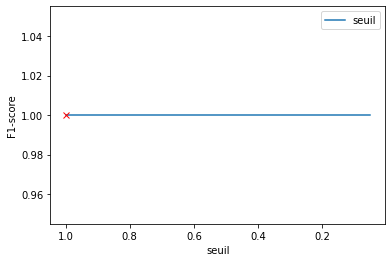

In [23]:
ss,fl,f,seuil=learn_threshold(predict,seq_df.label)
print(seuil,f)
plot_threshold(ss,fl,f,seuil)

In [ ]:
y_pred=decision(predict,seuil)
print(y_pred)

assert(len(seq_df)==len(y_pred))
# Display the confusion matrix
print(metrics.confusion_matrix(seq_df.label, y_pred))
# Calculate the classification rate of this classifier
p=metrics.accuracy_score(seq_df.label, y_pred)
r=metrics.recall_score(seq_df.label, y_pred, average='macro')
f1=metrics.f1_score(seq_df.label, y_pred, average='macro')
p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label, y_pred, average='micro')
print(f1,r,p)
savescore("UCADR.csv",p,r,f1,e,mu)

############ LSTM ########################

In [8]:
##load model and parameter
model = load_model('./LSTM/output_files/model.h5')
with open('./LSTM/output_files/config.dictionary', 'rb') as config_file:
    param = pickle.load(config_file)
#seqs=read_text_file("./LSTM/input_data/testseqs.txt")
#trainseq=[ deserialization(line) for line in seqs ]
def LSTMpred(seqs):
    start_time = time.perf_counter()
    SS=[anomalydetect([seq],param,model) for seq in [filterseq(seqs)[0]]]
    end_time=time.perf_counter()
    le=end_time-start_time
    return SS,le
#SS,le= LSTMpred(trainseq)
#SS,le= LSTMpred(list(seq_df.sequence))
#lmu=np.mean(memory_usage((LSTMpred,(list(seq_df.sequence),))))
print(SS)

NameError: name 'SS' is not defined

In [40]:
j=0
nbc=1
pert=.3
for i in range(15,150,15):
    nbitems=np.mean([len(s) for s in list(seq_df.sequence)[j:i]])
    SS,le= LSTMpred(list(seq_df.sequence)[j:i])
    lmu=np.mean(memory_usage((LSTMpred,(list(seq_df.sequence),))))
    print(SS)
    seuil=0.6
    #ss,fl,f,seuil=learn_threshold(SS,seq_df.label[j:i])
    y_pred=decision(SS,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    #print(metrics.confusion_matrix(seq_df.label[j:i], y_pred))
    # Calculate the classification rate of this classifier
    #p=metrics.accuracy_score(seq_df.label[j:i], y_pred)
    #r=metrics.recall_score(seq_df.label[j:i], y_pred, average='macro')
    #f1=metrics.f1_score(seq_df.label[j:i], y_pred, average='macro')
    #p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label[j:i], y_pred, average='micro')
    #print(f1,r,p)
    savescore("LSTM3.csv",p,r,f1,le,lmu)
    j=i

[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[0.9998610604634081]
[1]
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306

In [33]:
j=0
nbc=3
pert=.3
for s in trainseq[8:]:
    #s=filterseq([s])[0]
    nbitems=len(s)
    SS,le= LSTMpred([s])
    lmu=np.mean(memory_usage((LSTMpred,([s],))))
    print(SS)
    ss,fl,f,seuil=learn_threshold(SS,[seq_df.label[j]])
    y_pred=decision(SS,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    print(metrics.confusion_matrix([seq_df.label[j]], y_pred))
    # Calculate the classification rate of this classifier
    #p=metrics.accuracy_score(seq_df.label[j:i], y_pred)
    #r=metrics.recall_score(seq_df.label[j:i], y_pred, average='macro')
    #f1=metrics.f1_score(seq_df.label[j:i], y_pred, average='macro')
    p1,r1,f,_=metrics.precision_recall_fscore_support([seq_df.label[j]], y_pred, average='micro')
    print(f1,r,p)
    savescore("LSTM2.csv",p1,r1,f,le,lmu)
    j +=1

[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[0.9998610604634081]
[1]
[[1]]
1.0 1.0 1.0
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
119 119.41033469306097
66 66.21428065829807
115 116.25530454847548
67 70.77107959323459
84 0.147145324283176
[34, 36, 27, 14, 14, 29, 26] [34, 36, 27, 14, 14, 29, 26] 1.0
80 79.06391355726454
78 75.80714755588107
1

In [14]:
#seq_df.label=len(trainseq)*[1]
ss,fl,f,seuil=learn_threshold(SS,seq_df.label)
print(seuil,f)
plot_threshold(ss,fl,f,seuil)
y_pred=decision(SS,seuil)
print(y_pred)

# Calculate the classification rate of this classifier
lp=metrics.accuracy_score(seq_df.label, y_pred)
lr=metrics.recall_score(seq_df.label, y_pred, average='macro')
lf1=metrics.f1_score(seq_df.label, y_pred, average='macro')
print(lf1)

NameError: name 'seq_df' is not defined

In [23]:
#nbseq=14
pert=.3
#nbc=5
lmu=np.mean(memory_usage((LSTMpred,(list(seq_df.sequence),))))
# Display the confusion matrix
print(metrics.confusion_matrix(seq_df.label, y_pred))
savescore("LSTM.csv",lp,lr,lf1,le,lmu)

[[20  0]
 [40  0]]


################### train LSTM model ####################

In [9]:
################### train LSTM model ####################
#trainseq=DB_seq[:20]
i=15
#trainseq=DB_seq
saveobj("trainseq.dictionary".format(i),trainseq)
trainseq=loadobj("trainseq.dictionary".format(i))
#h=train(trainseq)
#divisor,divisor2,maxlen,target_chars,target_char_indices,target_indices_char,char_indices,chars=30.42142857142857, 109.41428571428571, 140, [2, 3, 6, 7, 10, 17, 18], {2: 0, 3: 1, 6: 2, 7: 3, 10: 4, 17: 5, 18: 6}, {0: 2, 1: 3, 2: 6, 3: 7, 4: 10, 5: 17, 6: 18}, {2: 0, 3: 1, 6: 2, 7: 3, 10: 4, 17: 5, 18: 6}, [2, 3, 6, 7, 10, 17, 18]

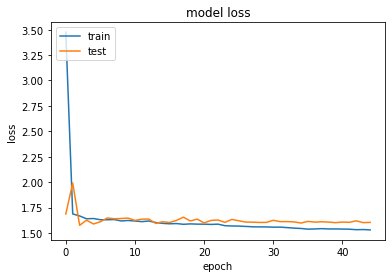

In [7]:
# summarize history for loss
history=h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
BCL=[]
for i,p in enumerate(y_pred):
    if(p==1):
        BCL.append(DB_c[i])
print(len(BCL))
i=15
saveobj("ch{0}/BCL29.dictionary".format(i),BCL)

10


In [23]:
y=SS
y

[array([[ 2.0944204 ,  0.7343619 ],
        [ 2.7888572 ,  0.682957  ],
        [ 2.4754608 ,  0.39624166],
        [ 1.9589406 , -0.35089982],
        [ 2.1714048 ,  0.47027677],
        [ 2.38188   ,  0.8893176 ],
        [ 2.1858795 ,  0.87145436],
        [ 1.8950516 ,  0.81917816],
        [ 1.6558878 ,  0.7949881 ],
        [ 1.4681236 ,  0.7735581 ],
        [ 1.3261917 ,  0.75293237],
        [ 1.1558357 ,  0.6805368 ]], dtype=float32)]

In [26]:
y[0][0] #list t
y[0][2][1]

0.39624166

In [17]:
#from LSTM.LSTMretrain import retrain
#model = load_model('./LSTM/output_files/model_482-1.85.h5')
#retrain(trainseq[:5],param,model)

###################################### UCAD multi THREAD #######################
###############################################################################

In [16]:
print("======== ThreadPoolExecutor Parallel research for a sequence in the chronicle database  =======")
def UCADTHpred(seqs):
    start_time = time.perf_counter()
    predict=syn(DB_ch,seqs,5)
    end_time=time.perf_counter()
    e=end_time - start_time
    return predict ,e
predict,e=UCADTHpred(list(seq_df.sequence))
mu=np.mean(memory_usage((UCADTHpred,(seq_df.sequence.tolist(),))))
print(predict)

======== ThreadPoolExecutor Parallel research for a sequence in the chronicle database  =======
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9231, 0.9231, 0.8869, 0.8869, 0.9608, 0.9231, 0.7866, 0.8187, 0.7866, 0.9231, 0.1108, 0.0872, 0.0518, 0.0944, 0.0539, 0.0944, 0.3679, 0.0659, 0, 0]


0.75 1.0


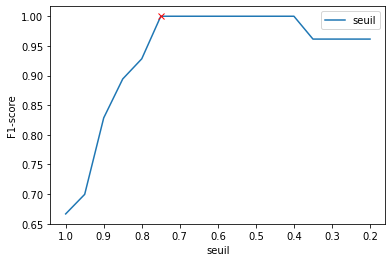

In [17]:
ss,fl,f,seuil=learn_threshold(predict,seq_df.label)
print(seuil,f)
plot_threshold(ss,fl,f,seuil)

In [18]:
y_pred=decision(predict,seuil)
print(y_pred)

assert(len(seq_df)==len(y_pred))
# Display the confusion matrix
print(metrics.confusion_matrix(seq_df.label, y_pred))
# Calculate the classification rate of this classifier
p=metrics.accuracy_score(seq_df.label, y_pred)
r=metrics.recall_score(seq_df.label, y_pred, average='macro')
f1=metrics.f1_score(seq_df.label, y_pred, average='macro')
p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label, y_pred, average='micro')
print(f1,r,p)
savescore("UCADTH.csv",p,r,f1,e,mu)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10  0]
 [ 0 20]]
1.0 1.0 1.0
